### Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import cross_val_score
from statistics import mean
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

#### Importation du dataset

In [2]:
df = pd.read_csv('../input/heart.csv')

##### Contenu des 5 premières lignes

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


##### Information sur les données

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


###### Analyse rapide (nomnbre, moyenne, écart type, minimum, maximum, quartiles)

In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


##### Dimensions du tableau (nombre de lignes et colonnes)

In [6]:
df.shape

(303, 14)

##### Nombre de valeurs

##### Noms des colonnes

In [7]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

##### Valeurs manquantes

In [8]:
pd.isnull(df).sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

### Histogrammes par données

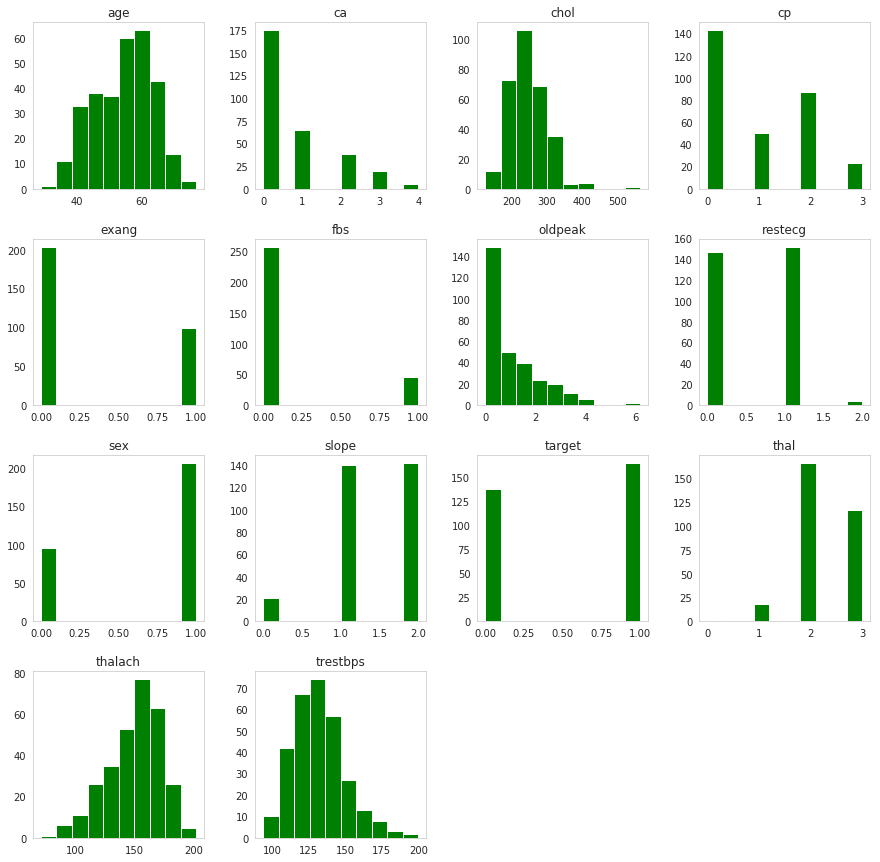

In [9]:
df.hist(bins=10,figsize=(15,15),color= "green", grid=False)
plt.show()

### Matrice de corrélation (liens entres données)

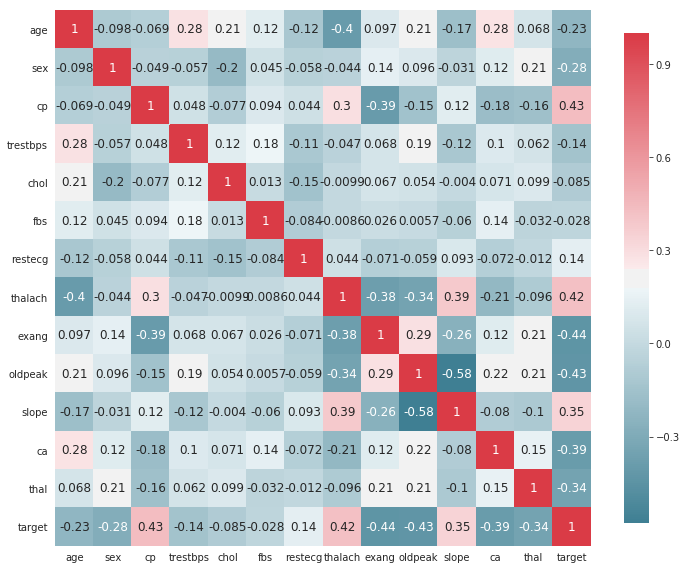

In [10]:
# Matrice couleur des données
def plot_correlation_map( df ):
    corr = df[['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', #ou tout simplement: df.corr()
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']].corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
plot_correlation_map(df)

##### Importance des données

In [11]:
corr = df.corr()['target'].abs().sort_values()
corr

fbs         0.028046
chol        0.085239
restecg     0.137230
trestbps    0.144931
age         0.225439
sex         0.280937
thal        0.344029
slope       0.345877
ca          0.391724
thalach     0.421741
oldpeak     0.430696
cp          0.433798
exang       0.436757
target      1.000000
Name: target, dtype: float64

#### Visualisation des malades par sex

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


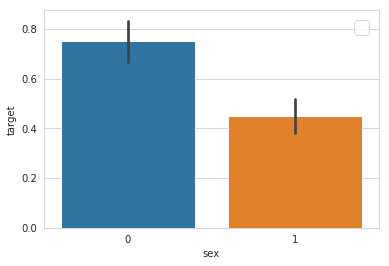

In [12]:
def plot_cat(data, x_axis, y_axis, hue):
    plt.figure()    
    sns.barplot(x=x_axis, y=y_axis, hue=hue, data=data)
    sns.set_context("notebook", font_scale=1.6)
    plt.legend(loc="upper right", fontsize="medium")
plot_cat(df,"sex", "target", None) 

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


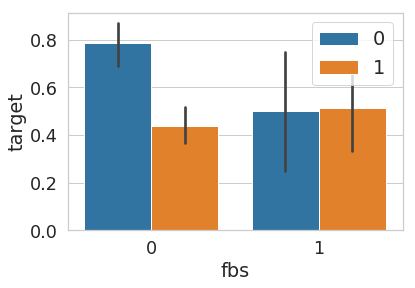

In [13]:
plot_cat(df,"fbs", "target", "sex") 

## Prédiction
#### On définie la cible "y" et les paterns "x"

In [14]:
X= df.drop('target',axis=1)  # on peut aussi donner les valeurs de x et de y
y=df['target']

### Réduction de la taille des variables 
"pour faciliter le travail des algorithmes"

In [15]:
# MinMaxScaler
X['trestbps'] = MinMaxScaler().fit_transform(X['trestbps'].values.reshape(-1, 1))
X['chol'] = MinMaxScaler().fit_transform(X['chol'].values.reshape(-1, 1))
X['thalach'] = MinMaxScaler().fit_transform(X['thalach'].values.reshape(-1, 1))
X['age'] = MinMaxScaler().fit_transform(X['age'].values.reshape(-1, 1))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


#### On divise en deux le jeu de données : 80% pour entrainer et 20% pour tester

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Choix de l'algorithme

In [18]:
clf = LGBMClassifier(n_estimators=200, max_depth=5)

In [19]:
clf.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=5,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [20]:
scores = cross_val_score(clf,X,y,scoring='roc_auc', cv=5)
print('AUC')
print(np.mean(scores))
print(np.std(scores))

AUC
0.8733205066538401
0.028395312955654572


In [21]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)

1.0

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier()
params = {'n_neighbors':[i for i in range(1,33,2)]}

In [23]:
model = GridSearchCV(knn,params,cv=10)

In [24]:
model.fit(X_train,y_train)
model.best_params_           #print's parameters best values

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_neighbors': 7}

In [25]:
predict = model.predict(X_test)

### Précision et Matrice de confusion

In [26]:
from sklearn.metrics import accuracy_score,confusion_matrix
print('Accuracy Score: ',accuracy_score(y_test,predict))
print('Using k-NN we get an accuracy score of: ',
      round(accuracy_score(y_test,predict),5)*100,'%')

Accuracy Score:  0.8688524590163934
Using k-NN we get an accuracy score of:  86.885 %


In [27]:
cnf_matrix = confusion_matrix(y_test,predict)
cnf_matrix

array([[25,  4],
       [ 4, 28]])

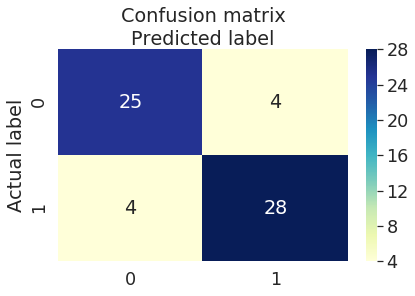

In [28]:
class_names = [0,1]
fig,ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

#create a heat map
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'YlGnBu',
           fmt = 'g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

### Importance des différentes données

In [29]:
coef = pd.Series(clf.feature_importances_, index = X.columns)
imp_coef = coef.sort_values(ascending=False)
print(imp_coef)

age         275
thalach     266
chol        252
trestbps    163
oldpeak     139
ca          128
sex          91
cp           67
slope        61
thal         53
exang        47
restecg      39
fbs          12
dtype: int64


Visualisation de l'importance des données

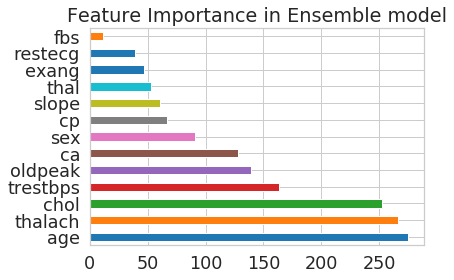

In [30]:
plt.title("Feature Importance in Ensemble model")
imp_coef.plot(kind="barh")
plt.show()